In [1]:
CITY = 2611606
CITY_NAME = 'Recife'
STATE = 'PE'
FILENAME_DATA = f'../../data/dengue_{CITY}_cluster.csv'
FILE_CHIK = f'../../data/chik_{CITY}_cluster.csv'

In [2]:
import sys
import pickle
sys.path.append('../..')
import numpy as np
import tensorflow as tf
import pandas as pd
from datetime import datetime
from pgbm_model import pgbm_pred
import matplotlib.pyplot as plt
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from plots_lstm import plot_loss, plot_comp 
from sklearn.metrics import mean_squared_error as mse 

In [3]:
df_dengue = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_2611606,casos_est_2611606,casos_est_min_2611606,casos_est_max_2611606,p_rt1_2611606,p_inc100k_2611606,temp_min_2611606,temp_max_2611606,umid_min_2611606,pressao_min_2611606,casos_2609600,casos_est_2609600,casos_est_min_2609600,casos_est_max_2609600,p_rt1_2609600,p_inc100k_2609600,temp_min_2609600,temp_max_2609600,umid_min_2609600,pressao_min_2609600
2010-01-03,3,3.0,3,3,0.000000,0.181438,23.566655,29.759870,65.694005,0.996910,0,0.0,0,0,0.000000,0.000000,24.916591,28.483477,72.747520,0.996870
2010-01-10,1,1.0,1,1,0.000000,0.060479,23.361964,28.853036,67.720482,0.997645,0,0.0,0,0,0.000000,0.000000,24.849640,28.135044,72.020724,0.997587
2010-01-17,2,2.0,2,2,0.000000,0.120958,23.713884,28.708514,66.979735,0.999090,1,1.0,1,1,0.000000,0.254379,25.096527,28.133724,71.021156,0.998979
2010-01-24,1,1.0,1,1,0.000000,0.060479,23.133310,28.117144,72.603921,0.997980,0,0.0,0,0,0.000000,0.000000,24.699236,27.566624,75.733819,0.997844
2010-01-31,0,0.0,0,0,0.000000,0.000000,23.832231,29.365596,70.365346,0.996689,0,0.0,0,0,0.000000,0.000000,24.933786,28.324955,75.165093,0.996633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-19,138,207.0,167,272,0.991736,12.519195,23.319445,29.347922,65.023093,0.997163,8,12.0,8,36,0.007849,3.052542,24.543261,28.324842,71.254825,0.997108
2023-03-26,103,187.0,140,277,0.449656,11.309610,23.407008,28.624516,69.804000,0.998097,1,7.5,1,53,0.000863,1.907839,24.559213,27.799722,76.674585,0.997903
2023-04-02,71,169.0,119,267,0.078816,10.220985,23.293021,29.136257,65.368153,0.997864,1,9.0,1,79,0.079855,2.289406,24.869830,28.264430,71.060175,0.997779
2023-04-09,69,177.0,113,320,0.301938,10.704819,23.688411,28.953186,70.620498,0.996426,0,9.0,0,121,0.390062,2.289406,25.024527,28.156577,74.921788,0.996308


## Neural network model 

Parameters of the models:

In [4]:
END_DATE_TRAIN ='2021-01-03'# assign the last day used to evaluate the dengue model 
END_DATE = '2022-01-02'

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
BATCH_SIZE = 1
EPOCHS = 400
HIDDEN = 8
FEAT = 28 # number of features
l1 = 1e-6
l2 = 1e-6

Let's train the model with the loss function == msle 

Now, let's retrain the models with all the data available to apply the transfer learning step later:

Compilation Time :  0.0033571720123291016
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 28)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             2368      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 4)                 36        
                   

2023-05-06 23:31:02.197934: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


121/121 [==============================] - 3s 7ms/step - loss: 0.0144 - accuracy: 0.2183 - mape: 5007670.5000 - mse: 0.0235 - val_loss: 0.0218 - val_accuracy: 0.1529 - val_mape: 4857835.5000 - val_mse: 0.0394
Epoch 2/400
121/121 [==============================] - 1s 4ms/step - loss: 0.0108 - accuracy: 0.2287 - mape: 4127079.2500 - mse: 0.0185 - val_loss: 0.0123 - val_accuracy: 0.1765 - val_mape: 1008594.5625 - val_mse: 0.0243
Epoch 3/400
121/121 [==============================] - 1s 4ms/step - loss: 0.0046 - accuracy: 0.2911 - mape: 648891.5000 - mse: 0.0082 - val_loss: 0.0071 - val_accuracy: 0.3176 - val_mape: 314392.7812 - val_mse: 0.0146
Epoch 4/400
121/121 [==============================] - 1s 4ms/step - loss: 0.0036 - accuracy: 0.2640 - mape: 879558.4375 - mse: 0.0063 - val_loss: 0.0077 - val_accuracy: 0.2824 - val_mape: 267599.2188 - val_mse: 0.0153
Epoch 5/400
121/121 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 0.2599 - mape: 1446218.1250 - mse: 0.0

121/121 [==============================] - 1s 4ms/step - loss: 0.0020 - accuracy: 0.3056 - mape: 408677.7500 - mse: 0.0032 - val_loss: 0.0057 - val_accuracy: 0.3294 - val_mape: 234286.6875 - val_mse: 0.0116
Epoch 76/400
121/121 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.3160 - mape: 404320.8125 - mse: 0.0036 - val_loss: 0.0053 - val_accuracy: 0.2588 - val_mape: 530580.2500 - val_mse: 0.0111
Epoch 77/400
121/121 [==============================] - 0s 4ms/step - loss: 0.0020 - accuracy: 0.2973 - mape: 371271.1250 - mse: 0.0033 - val_loss: 0.0039 - val_accuracy: 0.2941 - val_mape: 474100.6562 - val_mse: 0.0068
Epoch 78/400
121/121 [==============================] - 0s 4ms/step - loss: 0.0020 - accuracy: 0.3077 - mape: 544944.3125 - mse: 0.0033 - val_loss: 0.0053 - val_accuracy: 0.3294 - val_mape: 455205.1875 - val_mse: 0.0109
Epoch 79/400
121/121 [==============================] - 0s 4ms/step - loss: 0.0019 - accuracy: 0.2973 - mape: 536561.9375 - mse: 0.00

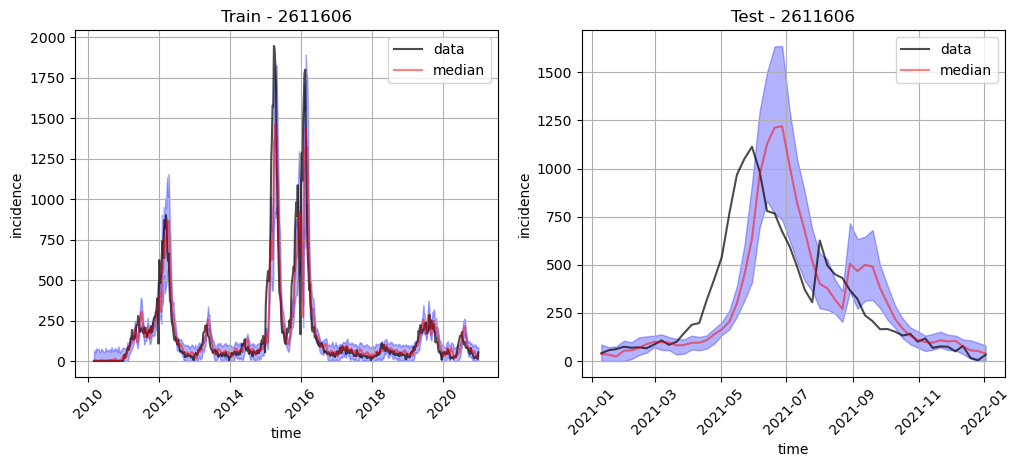

In [5]:
model = build_model(l1=l1, l2 = l2, hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=BATCH_SIZE, loss = 'msle', lr = 0.001)

m_msle_all, h_msle_all, m_train_all, m_val_all = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = END_DATE_TRAIN, 
                    ratio= None, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle_all',  filename = FILENAME_DATA)


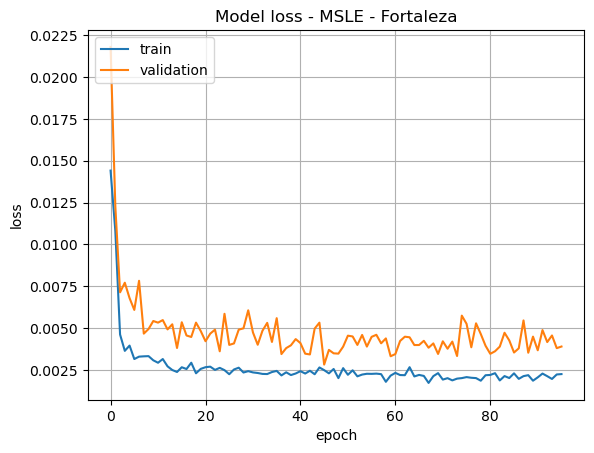

In [6]:
plot_loss(h_msle_all, title = 'Model loss - MSLE')

PGBM model

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 276.8830
Estimator 1/100, Train metric: 252.8314
Estimator 2/100, Train metric: 231.1208
Estimator 3/100, Train metric: 211.4498
Estimator 4/100, Train metric: 193.6384
Estimator 5/100, Train metric: 177.5787
Estimator 6/100, Train metric: 163.0200
Estimator 7/100, Train metric: 149.8949
Estimator 8/100, Train metric: 138.0177
Estimator 9/100, Train metric: 127.3189
Estimator 10/100, Train metric: 117.0213
Estimator 11/100, Train metric: 107.6774
Estimator 12/100, Train metric: 99.3852
Estimator 13/100, Train metric: 91.6950
Estimator 14/100, Train metric: 84.6722
Estimator 15/100, Train metric: 78.2793
Estimator 16/100, Train metric: 72.4188
Estimator 17/100, Train metric: 67.0566
Estimator 18/100, Train metric: 61.9075
Estimator 19/100, Train metric: 57.2608
Estimator 20/100, Train metric: 53.1537
Estimator 21/100, Train metric: 49.2811
Estimator 22/100, Train metric: 45.8090
Estimator 23/100, Train metric: 42.6458
Estimator 24/100, Train metric: 39.813

Estimator 7/100, Train metric: 154.9987
Estimator 8/100, Train metric: 143.3962
Estimator 9/100, Train metric: 132.7873
Estimator 10/100, Train metric: 123.0211
Estimator 11/100, Train metric: 113.5256
Estimator 12/100, Train metric: 104.9455
Estimator 13/100, Train metric: 97.2903
Estimator 14/100, Train metric: 90.0860
Estimator 15/100, Train metric: 83.5072
Estimator 16/100, Train metric: 77.5085
Estimator 17/100, Train metric: 72.2184
Estimator 18/100, Train metric: 67.3408
Estimator 19/100, Train metric: 62.9382
Estimator 20/100, Train metric: 58.8666
Estimator 21/100, Train metric: 55.1909
Estimator 22/100, Train metric: 51.6784
Estimator 23/100, Train metric: 48.5163
Estimator 24/100, Train metric: 45.5333
Estimator 25/100, Train metric: 42.8146
Estimator 26/100, Train metric: 40.4325
Estimator 27/100, Train metric: 37.8800
Estimator 28/100, Train metric: 35.8818
Estimator 29/100, Train metric: 33.7293
Estimator 30/100, Train metric: 31.7913
Estimator 31/100, Train metric: 30.11

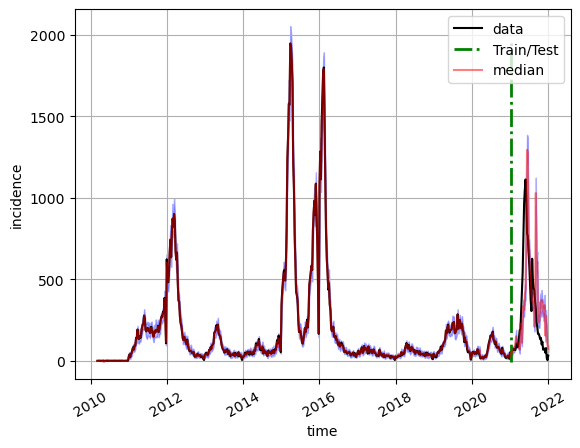

In [7]:
preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_DATE_TRAIN, end_date = END_DATE,  filename = FILENAME_DATA)
   